# Analyse finished quintuplicate runs

In [22]:
#check cresset notebooks on HA analyses. 
import matplotlib.pyplot as plt 
import pandas as pd
import glob
import itertools

from rdkit import Chem
from rdkit.Chem import Draw, rdFMCS, AllChem, rdmolfiles, Descriptors

In [5]:
compiled_mbar_quintups = pd.read_csv("compiled_mbar_freenrgs.csv")
compiled_mbar_quintups

,pert,freenrg_1,freenrg_2,freenrg_3,freenrg_4,freenrg_5,SEM
0,mobley_1662128~mobley_7047032,-25.109701,-24.950297,-25.008084,-25.010547,-25.793348,0.156846
1,mobley_7015518~mobley_303222,17.833264,16.627897,17.715131,17.002873,17.150193,0.108653
2,mobley_1046331~mobley_3515580,17.861679,17.985948,18.469134,18.304531,18.315318,0.113167
3,mobley_1563176~mobley_5935995,2.311669,2.125655,2.485517,2.239475,2.757905,0.110221
4,mobley_1717215~mobley_3982371,-20.648742,-20.214194,-20.224504,-20.334439,-20.313983,0.079038
...,...,...,...,...,...,...,...
2715,mobley_1650157~mobley_1261349,26.988781,26.947149,27.037841,26.950186,26.898652,0.023249
2716,mobley_7200804~mobley_4494568,-6.380436,-5.455188,-7.264557,-6.496928,-6.770592,0.296665
2717,mobley_1827204~mobley_9883303,3.983134,4.015559,3.768399,4.021287,3.901136,0.047493
2718,mobley_1199854~mobley_9185328,-1.083444,-0.682731,-1.053471,-0.963844,-1.003015,0.071653


### SEM vs HA

In [26]:
# loop over all freesolv PDBs, make dict with ligname and numHA, then compute dHA; plot.
# do same for MW? 

frslv_path = "/home/jscheen/projects/HYDRA_LEARN/FREESOLV/"

perts = []
sem_values = []
n_ha_scores = []
dmw_values = []

for pert, sem in zip(compiled_mbar_quintups["pert"], compiled_mbar_quintups["SEM"]):
    
    ligA = rdmolfiles.MolFromPDBFile(frslv_path+pert.split("~")[0]+".pdb")
    ligB = rdmolfiles.MolFromPDBFile(frslv_path+pert.split("~")[1]+".pdb")
    
    dMW = abs(Descriptors.ExactMolWt(ligB) - Descriptors.ExactMolWt(ligA))
    
    mcs = rdFMCS.FindMCS([ligA, ligB])
    
    fragA = Chem.ReplaceCore(ligA, Chem.MolFromSmarts(mcs.smartsString))
    fragB = Chem.ReplaceCore(ligB, Chem.MolFromSmarts(mcs.smartsString))
    
    # sometimes with very small molecules there is a single-atom MCS which fails in core replacement. Ignore these.
    if fragA and fragB:

        fragA_smiles = Chem.MolToSmiles(fragA)
        fragB_smiles = Chem.MolToSmiles(fragB)

        # assign a score based on n_ha transformed:
        transform_score = 0
        for frag_A, frag_B in itertools.zip_longest(fragA_smiles.split("."), fragB_smiles.split(".")):
            if frag_A == None:
                fragA_atoms = "X"
            elif frag_B == None:
                fragB_atoms == "X"
            else:
                fragA_atoms = frag_A[4:].replace("(", "").replace(")", "").replace("+", "").replace("-", "")
                fragB_atoms = frag_B[4:].replace("(", "").replace(")", "").replace("+", "").replace("-", "")


            if len(fragA_atoms) == len(fragB_atoms):
                transform_score += 1
            elif len(fragA_atoms) != len(fragB_atoms):
                if len(fragA_atoms) > len(fragB_atoms):
                    transform_score += len(fragA_atoms)
                else:
                    transform_score += len(fragB_atoms)
        perts.append(pert)
        n_ha_scores.append(transform_score)
        dmw_values.append(dMW)
        sem_values.append(sem)
  
    

                              Total number of quintuplicates: 2693


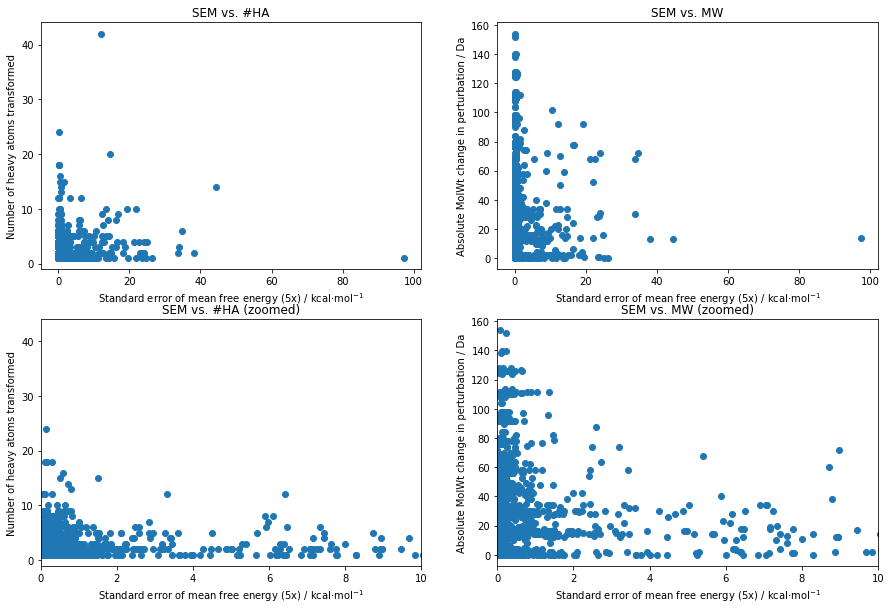

In [48]:
# plot.
fig, axes = plt.subplots(2,2, figsize=(15,10))
axes[0][0].scatter(sem_values, n_ha_scores)
axes[0][0].set_title("SEM vs. #HA")
axes[0][0].set_ylabel("Number of heavy atoms transformed")
axes[0][0].set_xlabel("Standard error of mean free energy (5x) / kcal$\cdot$mol$^{-1}$")


axes[0][1].scatter(sem_values, dmw_values)
axes[0][1].set_title("SEM vs. MW")
axes[0][1].set_ylabel("Absolute MolWt change in perturbation / Da")
axes[0][1].set_xlabel("Standard error of mean free energy (5x) / kcal$\cdot$mol$^{-1}$")

axes[1][0].scatter(sem_values, n_ha_scores)
axes[1][0].set_title("SEM vs. #HA (zoomed)")
axes[1][0].set_ylabel("Number of heavy atoms transformed")
axes[1][0].set_xlabel("Standard error of mean free energy (5x) / kcal$\cdot$mol$^{-1}$")
axes[1][0].set_xlim(0, 10)


axes[1][1].scatter(sem_values, dmw_values)
axes[1][1].set_title("SEM vs. MW (zoomed)")
axes[1][1].set_ylabel("Absolute MolWt change in perturbation / Da")
axes[1][1].set_xlabel("Standard error of mean free energy (5x) / kcal$\cdot$mol$^{-1}$")
axes[1][1].set_xlim(0, 10)
print("                              Total number of quintuplicates:", len(sem_values))
plt.show()

### Cross-scaffold SEM

Check if for a given perturbation the scaffold makes a difference. Do this by finding duplicates in the smartsstring and checking the SEMs.

In [60]:
frslv_path = "/home/jscheen/projects/HYDRA_LEARN/FREESOLV/"

handled_rxns = []


for pert, sem in zip(compiled_mbar_quintups["pert"], compiled_mbar_quintups["SEM"]):
    
    ligA = rdmolfiles.MolFromPDBFile(frslv_path+pert.split("~")[0]+".pdb")
    ligB = rdmolfiles.MolFromPDBFile(frslv_path+pert.split("~")[1]+".pdb")

    mcs = rdFMCS.FindMCS([ligA, ligB])
    
    fragA = Chem.ReplaceCore(ligA, Chem.MolFromSmarts(mcs.smartsString))
    fragB = Chem.ReplaceCore(ligB, Chem.MolFromSmarts(mcs.smartsString))
    
    # sometimes with very small molecules there is a single-atom MCS which fails in core replacement. Ignore these.
    if fragA and fragB:

        fragA_smiles = Chem.MolToSmiles(fragA)
        fragB_smiles = Chem.MolToSmiles(fragB)
        
        rxn_smiles = fragA_smiles+"~"+fragB_smiles
        if len(rxn_smiles) > 1:
            handled_rxns.append([rxn_smiles, sem])


In [96]:
# group the list by reaction smiles and take a distribution of the SEMs.

# get a set of unique rxn names.
rxns_uniq = set(map(lambda x:x[0], handled_rxns))

# grab the freenrgs for this pert name as a list.
rxns_grouped = [[y[1] for y in handled_rxns if y[0]==x] for x in rxns_uniq]




collection_rxn_sems = []
for rxn, sems in zip(rxns_uniq, rxns_grouped):
    if len(sems) > 1:
        collection_rxn_sems.append([rxn]+sems)
collection_rxn_sems.sort(key=len, reverse=True)

for rxn in collection_rxn_sems[:20]:   
    rxn_name = rxn[0]
    sems = rxn[1:]
    print(rxn_name, "\t\t", len(sems))



~[1*]C 		 110
[1*]C~ 		 90
[1*]C~[1*]C 		 69
[1*]C~[1*]O 		 68
[1*]O~[1*]C 		 66
[1*]O~ 		 53
~[1*]O 		 46
[1*]C.[2*]C~ 		 42
[1*]O~[1*]O 		 32
[1*]CC~ 		 32
~[1*]CC 		 31
[1*]Cl~[1*]C 		 30
[1*]C~[1*]Cl 		 30
[1*]Cl~ 		 30
~[1*]Cl 		 30
[1*]C~[1*]N 		 24
[1*]C~[1*]C.[2*]C 		 24
[1*]C.[2*]C~[1*]O 		 20
[1*]Cl~[1*]O 		 20
[1*]O~[1*]N 		 19


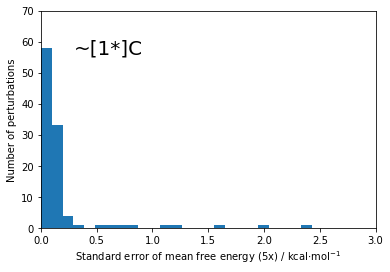

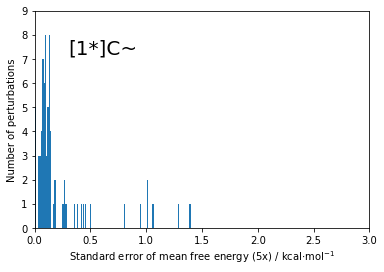

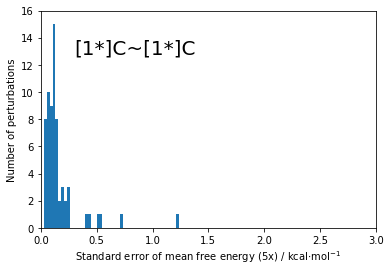

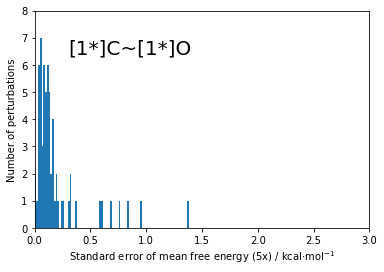

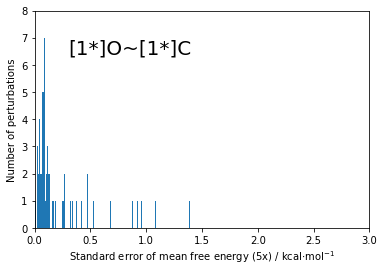

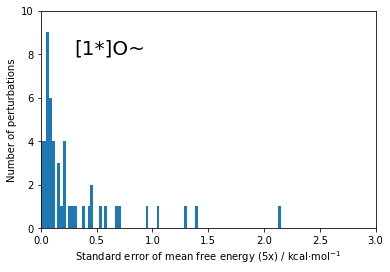

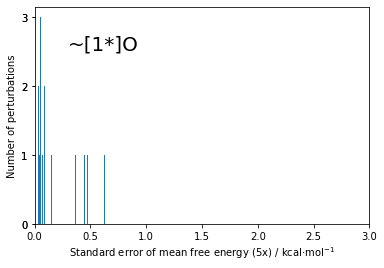

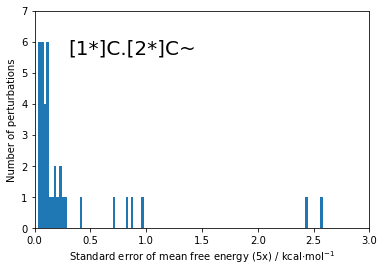

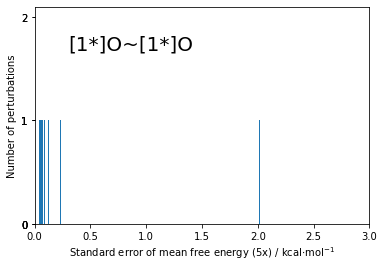

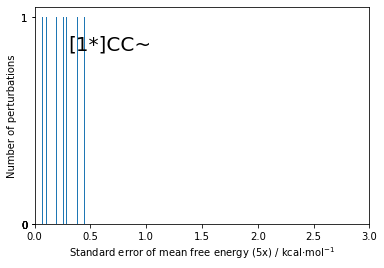

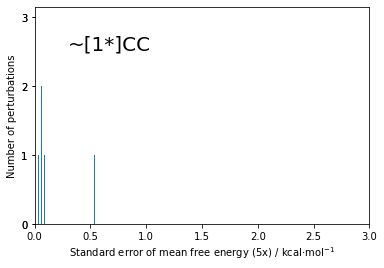

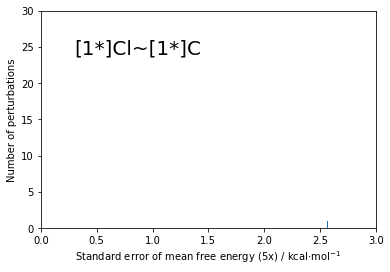

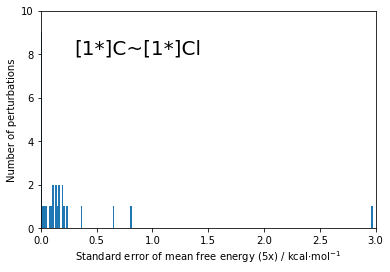

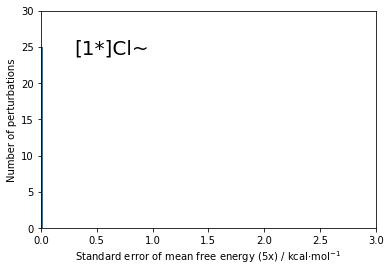

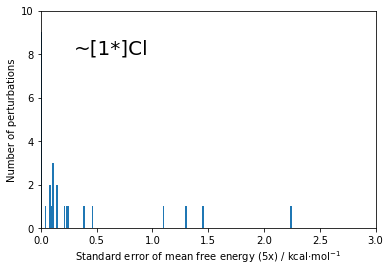

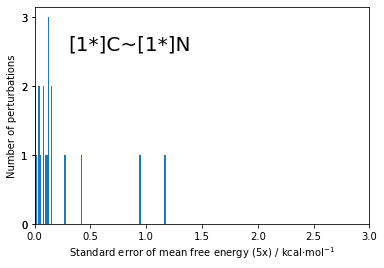

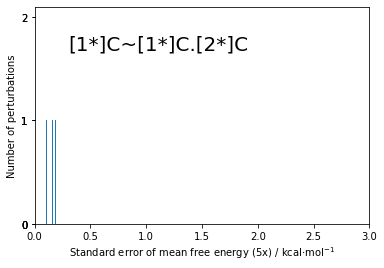

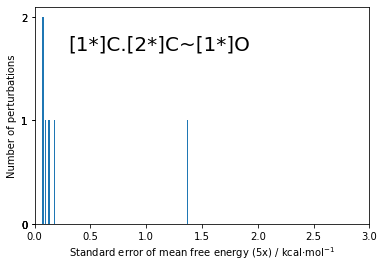

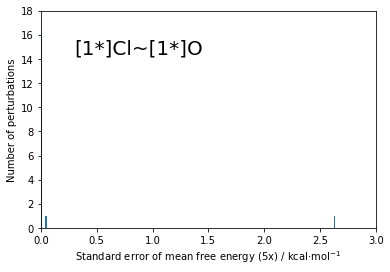

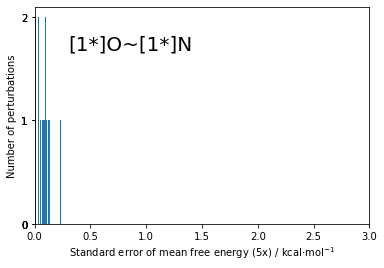

In [99]:
for rxn in collection_rxn_sems[:20]:   
    rxn_name = rxn[0]
    sems = rxn[1:]

    plt.hist(sems, density=False, bins=1000)
    plt.annotate(rxn_name, xy=(0.1,0.8), xycoords="axes fraction", size=20)
    plt.xlim(0,3)
    plt.ylabel("Number of perturbations")
    plt.xlabel("Standard error of mean free energy (5x) / kcal$\cdot$mol$^{-1}$")
    # make the y ticks integers, not floats
    yint = []
    locs, labels = plt.yticks()
    for each in locs:
        yint.append(int(each))
    plt.yticks(yint)
    plt.show()